In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

#### 创建一个简单的数据集 用于验证简单的CBOW模型

In [2]:
sentences = [
    'Kage is Teacher',
    'Mazong is Boss',
    'Niuzong is Boss',
    'Xiaobing is Student',
    'Xiaoxue is Student'
]

words = ' '.join(sentences).split()
wordlist = list(set(words))
word_to_idx = {word:idx for idx, word in enumerate(wordlist)}
idx_to_word = {idx:word for idx, word in enumerate(wordlist)}
voc_size = len(wordlist)

#### 生成 CBOW 数据集

In [3]:
def create_cbow_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            context = sentence[max(0, idx-window_size):idx] + 
            sentence[idx+1:min(idx+window_size+1, len(sentence))]
            data.append((word, context))
    return data

In [4]:
cbow_data = create_cbow_dataset(sentences)

#### 进行one-hot编码

In [5]:
def one_hot_embedding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor

In [6]:
one_hot_embedding('Kage', word_to_idx), word_to_idx['Kage']

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 3)

#### 定义CBOW类型

In [7]:
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias = False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias = False)
    
    def forward(self, x):
        embedding = self.input_to_hidden(x)
        hidden_layer = torch.mean(embedding, dim=0)
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0))
        return output_layer

#### 训练 CBOW 模型

In [10]:
learning_rate = 0.001
epochs = 3000
cbow_model = CBOW(voc_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=cbow_model.parameters(), lr=learning_rate)

loss_values = []
for epoch in range(epochs):
    loss_sum = 0
    for traget, contexts in cbow_data:
        x = torch.stack([one_hot_embedding(context, word_to_idx) for context in contexts]).float()
        y_true = torch.tensor(word_to_idx[traget], dtype=torch.long).unsqueeze(0)
        y_pred = cbow_model(x)
        loss = criterion(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch:{epoch+1}, Loss:{loss_sum / len(cbow_data)}")
        loss_values.append(loss_sum / len(cbow_data))

Epoch:100, Loss:2.178321441014608
Epoch:200, Loss:2.1680161555608115
Epoch:300, Loss:2.1572810411453247
Epoch:400, Loss:2.1455679098765055
Epoch:500, Loss:2.132300066947937
Epoch:600, Loss:2.116826550165812
Epoch:700, Loss:2.098378332455953
Epoch:800, Loss:2.076028275489807
Epoch:900, Loss:2.0486605008443197
Epoch:1000, Loss:2.014968244234721
Epoch:1100, Loss:1.973512355486552
Epoch:1200, Loss:1.922896917661031
Epoch:1300, Loss:1.8621316830317178
Epoch:1400, Loss:1.7912085930506387
Epoch:1500, Loss:1.711743450164795
Epoch:1600, Loss:1.627231280008952
Epoch:1700, Loss:1.5424003024895987
Epoch:1800, Loss:1.461809633175532
Epoch:1900, Loss:1.388579245408376
Epoch:2000, Loss:1.3239681482315064
Epoch:2100, Loss:1.2677437285582225
Epoch:2200, Loss:1.218855294585228
Epoch:2300, Loss:1.1759864747524262
Epoch:2400, Loss:1.1378802925348281
Epoch:2500, Loss:1.103483143945535
Epoch:2600, Loss:1.0719762628277143
Epoch:2700, Loss:1.0427607576052347
Epoch:2800, Loss:1.0154207170009613
Epoch:2900, Los

#### 画出loss曲线

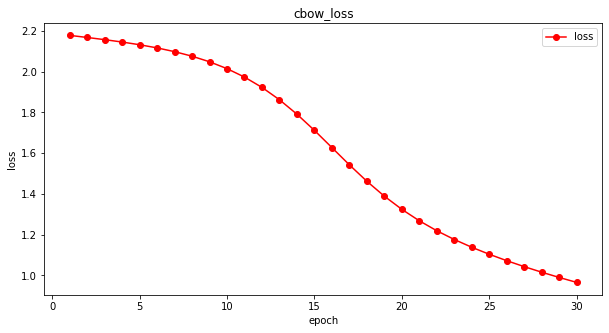

In [21]:
# 设置图形大小
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_values)+1), loss_values, 'ro-', label="loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('cbow_loss')
plt.legend()
plt.show()

#### Skip-Garm 和 CBOW 的区别

|模型|训练目标|结构|性能|
|----|----|--|--|
|Skip-Gram模型|给定一个目标词，预测上下文词。因此，它的训练目标是在给定目标词的情况下，使上下文出现的条件概率最大化|模型首先是将目标词映射到嵌入向量空间，然后从嵌入向量空间映射回词汇表空间以预测上下文词的概率分布|由于其目的是预测多个上下文词，其在捕捉稀有词和更复杂的词语关系方面表现得更好|
|CBOW模型|给定上下文词，预测目标词。因此它的训练目标是在给定上下文的情况下，使目标词出现的条件概率最大化|模型首先将上下文词汇映射到嵌入向量空间，然后从嵌入向量空间映射回词汇表空间以预测目标词的概率分布|由于其目标是预测一个目标词，其在训练速度和捕捉高频词语关系方面表得更好|

#### word2vec缺点：

- 词向量大小是固定的。word2vec这种“在全部语料上一次性学习，然后反复使用”的词向量成为静态词向量。它为每个单词声称一个固定大小的向量，这个限制了模型捕捉词义多样性的能力。
- 无法实现一词多义，在自然语言中，许多单词具有多种含义，但word2vec无法为这些不同的含义生成多个向量表示。
- 无法处理未知词汇。word2vec只能为训练过程中出现过的单词生成词向量。